# Assignment 3

# Instructions

1. You have to use only this notebook for all your code.
2. All the results and plots should be mentioned in this notebook.
3. For final submission, submit this notebook along with the report ( usual 2-4 pages, latex typeset, which includes the challenges faces and details of additional steps, if any)
4. Marking scheme
    -  **60%**: Your code should be able to detect bounding boxes using resnet 18, correct data loading and preprocessing. Plot any 5 correct and 5 incorrect sample detections from the test set in this notebook for both the approached (1 layer and 2 layer detection), so total of 20 plots.
    -  **20%**: Use two layers (multi-scale feature maps) to detect objects independently as in SSD (https://arxiv.org/abs/1512.02325).  In this method, 1st detection will be through the last layer of Resnet18 and the 2nd detection could be through any layer before the last layer. SSD uses lower resolution layers to detect larger scale objects. 
    -  **20%**: Implement Non-maximum suppression (NMS) (should not be imported from any library) on the candidate bounding boxes.
    
5. Report AP for each of the three class and mAP score for the complete test set.

In [8]:
#from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import models
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import os
import copy
import cv2
from PIL import Image
import torch.nn.functional as F
import math
import matplotlib.patches as patches

%matplotlib inline
plt.ion()
# size of resnet18 input images
resnet_input = 224               

In [85]:
# Choose your hyper-parameters using validation data
batch_size = 32
num_epochs = 7
learning_rate =  0.001
hyp_momentum = 0.9

## Build the data
Use the following links to locally download the data:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>The dataset consists of images from 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, i.e. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the three classes(aeroplane, bottle, chair). For parsing the xml file, you can import xml.etree.ElementTree for you. <br/>
<br/> Organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be four. This is important for applying the sliding window method later.


In [28]:
classes = ('__background__',
           'aeroplane',
           'bottle','chair'
           )

In [29]:
def iou(box1, box2):
    # Find iou of the two boxes by computing the ratio of intersection area by union area
    
    [x_min_1, y_min_1, x_max_1, y_max_1] = box1.tolist()
    [x_min_2, y_min_2, x_max_2, y_max_2] = box2.tolist()
    delta_x = min(x_max_1,x_max_2)-max(x_min_1,x_min_2)
    delta_y = min(y_max_1,y_max_2)-max(y_min_1,y_min_2)
    if delta_x<=0 or delta_y<=0 : return 0
    area_1 = (x_max_1 - x_min_1) * (y_max_1 - y_min_1)
    area_2 = (x_max_2 - x_min_2) * (y_max_2 - y_min_2)
    and_area = delta_x*delta_y
    or_area = area_1+area_2-and_area
    return and_area/or_area

def sliding_window_for_background(image, list_of_boxes, threshold =0.00001, step_size = 30, window_size = [150,150]):
    # returns background patches for an image given the bounding boxes of objects in it.
    
    '''take only those parts of image for background which has lower iou than threshold with
    all of the boxes of the three classes'''
    
    list_of_background=[]
    y=0
    x=0
    while y < image.shape[0] -window_size[1]:
        yflag = 0
        while x < image.shape[1] - window_size[0]:
            slide_box = [x,y,x+window_size[0],y+window_size[1]]   # background patch
            flag=0
            for i in range(len(list_of_boxes)):
                if iou(slide_box, list_of_boxes[i])>threshold:    # condition for iou
                    flag=1
                    yflag=1
                    break
            if flag:                                            #  flag means background condition not satisfied, 
                x = x + step_size                               #  move to the next window by a stride
            else : 
                list_of_background.append(slide_box)
                x = x + window_size[0]                          # if background condition satisfied, jump with winow size, not stride.
        if yflag:
            y = y + step_size
        else:
            y = y + window_size[1]            
                
    return list_of_background

In [ ]:
def build_test():
    ''' function to seperate the test images which have any one 
    of the three classes from the whole test corpus'''
    
    # Begin
    tots=0
    train_an = "/mnt/data/cv3/test/VOCdevkit/VOC2007/Annotations/"
    train_img = "/mnt/data/cv3/test/VOCdevkit/VOC2007/JPEGImages/"
    dest = "/mnt/data/cv3/test/VOCdevkit/VOC2007/Images/"
    bg=[]
    list = open("/mnt/data/cv3/test/VOCdevkit/VOC2007/list.txt", "w")
    for file in os.listdir(train_img):
        img_name = file.rsplit(".")[0]
        img = cv2.imread(train_img + file)
        tree = ET.parse(train_an + img_name + '.xml')
        root = tree.getroot()
        
        for child in root.iter('object'):
            name = child.find('name').text
            if name == 'aeroplane' or name == 'chair' or name == 'bottle':
                cv2.imwrite(dest+img_name+'.jpg', img)
                list.write(img_name + ".jpg\n")
                break

    list.close()        

In [ ]:
build_test()

In [86]:
def build_dataset():
    # Begin
    '''this function crops the bounding boxes from training images having any one of the three classes'''
    ''' background images from all images of PascalVOC dataset are extracted in this function itself'''

    train_an = "/mnt/data/cv3/trainval/VOCdevkit/VOC2007/Annotations/"
    train_img = "/mnt/data/cv3/trainval/VOCdevkit/VOC2007/JPEGImages/"
    dest = "/mnt/data/cv3/trainval/croped3/"
    
    # A file: labels is used to store the croped image name and it's class
    
    label_file = open('/mnt/data/cv3/trainval/labels2.txt','w')
    for file in os.listdir(train_img):
        img_name = file.rsplit(".")[0]
        img = cv2.imread(train_img + file)
        tree = ET.parse(train_an + img_name + '.xml')
        root = tree.getroot()
        id =0
        for child in root.iter('object'):
            id+=1
            name = child.find('name').text
            if name != 'aeroplane' and name != 'chair' and name != 'bottle':   # check if any one of the classes is present
                id-=1
                continue
            bndbox = child.find('bndbox')
            box=[]
            box.append(int(bndbox.find('xmin').text))
            box.append(int(bndbox.find('ymin').text))
            box.append(int(bndbox.find('xmax').text))
            box.append(int(bndbox.find('ymax').text))
            cv2.imwrite(dest + img_name + "_" + str(id)+".jpg" ,img[box[1]:box[3] ,box[0]:box[2]])   # crop and save
            label_file.write(img_name + "_" + str(id)+".jpg" + " " + name + '\n')
    
    # Background images
    l = 0
    bg=[]
    for file in os.listdir(train_img):
        img_name = file.rsplit(".")[0]
        img = cv2.imread(train_img + file)
        tree = ET.parse(train_an + img_name + '.xml')
        root = tree.getroot()
        id =0
        bd=[]
        for child in root.iter('object'):
            flag = 0
            name = child.find('name').text
            if name != 'aeroplane' and name != 'chair' and name != 'bottle':
                id+=1
                flag = 1
            bndbox = child.find('bndbox')
            box=[]
            box.append(int(bndbox.find('xmin').text))
            box.append(int(bndbox.find('ymin').text))
            box.append(int(bndbox.find('xmax').text))
            box.append(int(bndbox.find('ymax').text))
            if flag :    # if a bounding box for some other class, then sotre that as background as well.
                cv2.imwrite(dest + img_name + "_bg_" + str(id)+".jpg" ,img[box[1]:box[3] ,box[0]:box[2]])
                label_file.write(img_name + "_bg_" + str(id)+".jpg" + " " + classes[0] + '\n')
            
            bd.append(box)  # append all objects bounding boxes so that further background images don't overlap with them.
        
        new = sliding_window_for_background(img , bd)
        l = l + len(new)
        for x in new:
            id+=1
            cv2.imwrite(dest + img_name + "_bg_" + str(id)+".jpg" ,img[x[1]:x[3] ,x[0]:x[2]])
            label_file.write(img_name + "_bg_" + str(id)+".jpg" + " " + classes[0] + '\n')
    label_file.close()     

In [ ]:
build_dataset()

In [21]:
'''loads the image as PIL object. '''
def image_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [89]:
class voc_dataset(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    
    ''' Dataset Class, written from completely by us. It's job is to load and retunr train/test images along 
    woth their class labels/bounging boxes'''
    
    def __init__(self, root_dir, train, transform=None):
        # Begin
        self.train = train  # boolean to check if train or test
        if train:
            self.root_dir = os.path.join(root_dir , 'trainval')
            labels_path = os.path.join(self.root_dir, 'labels2.txt')
            self.names = [(name.split(" ")[0].strip() , name.split(" ")[1].strip()) for name in open(labels_path)]
            self.names = sorted(self.names , key=lambda x: x[1])
        else:
            self.root_dir = os.path.join(root_dir , 'test/VOCdevkit/VOC2007/')
            test_path = os.path.join(self.root_dir, 'list.txt')
            self.names = [name.strip() for name in open(test_path)]
            self.names = sorted(self.names , key=lambda x: x[1])
                    
        
        self.transform = transform            # transforms to be done 
        
    def __len__(self):
        # Begin
        return len(self.names)
        
    def __getitem__(self, idx):
        # Begin
        if self.train:
            name = self.names[idx][0]
            label = classes.index(self.names[idx][1])
            image_path = os.path.join(self.root_dir , 'croped2/' + name)  # load image
            img = image_loader(image_path)
            
            if self.transform is not None:
                img = self.transform(img)  # apply transforms
            
            return img, label   # return image's tensor and label
        
    def test_iter(self, idx):    # only for Testing.
        '''This function loads test image with index = idx, and return's  it's path and the list of bounding boxes:
        [class, x1,y1,x2,y2]'''
        
        image_name = self.names[idx]
        annot_path = os.path.join(self.root_dir , 'Annotations')
        image_path = os.path.join(self.root_dir , 'Images/' + image_name)
        img = image_path

        tree = ET.parse(os.path.join(annot_path , image_name.split('.')[0] + '.xml'))
        root = tree.getroot()
        id =0
        bounding_boxes=[]
        for child in root.iter('object'):
            label = []
            name = child.find('name').text
            if name != 'aeroplane' and name != 'chair' and name != 'bottle':
                continue
            label.append(classes.index(name))
            bndbox = child.find('bndbox')   # load bounding box
            label.append(int(bndbox.find('xmin').text))
            label.append(int(bndbox.find('ymin').text))
            label.append(int(bndbox.find('xmax').text))
            label.append(int(bndbox.find('ymax').text))
            bounding_boxes.append(np.array(label))

        return img, np.array(bounding_boxes)

## Train the netwok
<br/>You can train the network on the created dataset. This will yield a classification network on the 4 classes of the VOC dataset. 

In [90]:
#Train and Test transforms. 

train_transform = transforms.Compose([transforms.Resize((resnet_input,resnet_input)),
                                         transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize((resnet_input,resnet_input)),
                                        transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_dataset = voc_dataset(root_dir='/mnt/data/cv3/', train=True, transform=train_transform) # Supply proper root_dir
test_dataset = voc_dataset(root_dir='/mnt/data/cv3/', train=False, transform=test_transform) # Supply proper root_dir

In [35]:
# Creating Training - Validation Split

validation_split = .2
random_seed= 42
shuffle_dataset = True
trainval_size = len(train_dataset)
indices = list(range(trainval_size))
split = int(np.floor(validation_split * trainval_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [36]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,
                                           sampler = train_sampler)
val_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,
                                           sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {'train' : train_loader,
               'val' : val_loader,
               'test' : test_loader}

dataset_sizes = {'train': len(train_dataset)*0.8,
                 'val' : len(train_dataset)*0.2}

### Fine-tuning
Use the pre-trained network to fine-tune the network in the following section:

In [37]:
# Train function, common to both methods.
def train(model, criterion, optimizer, scheduler, num_epochs):
    # Begin
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val':
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [94]:
# One layer Detection model training
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 4)

# Add code for using CUDA here
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)


criterion = nn.CrossEntropyLoss()
# Update if any errors occur
optimizer = optim.SGD(resnet18.parameters(), learning_rate, hyp_momentum)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

%time resnet18_ft = train(resnet18, criterion, optimizer, exp_lr_scheduler,num_epochs=num_epochs)
torch.save(resnet18_ft , 'model_big.pth')

In [10]:
## Define concat resnet for Two layer detection
class resnet_concat(nn.Module):
    def __init__(self,model):
        super(resnet_concat, self).__init__()
        self.inner_features = nn.Sequential(*list(model.children())[:-3])
        self.outer_features = nn.Sequential(*list(model.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_features=768,out_features=4)

    def forward(self,x):
        y=self.inner_features(x)
        y=self.avgpool(y)
        y=y.view(y.size(0),-1)

        z=self.outer_features(x)
        z=self.avgpool(z)
        z=z.view(z.size(0),-1)

        x=torch.cat((y,z),1)
        x=self.fc(x)
        return x

In [95]:
# Two Layer Detection (SSD)
model_clip = resnet_concat(models.resnet18(pretrained=True))
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_clip.parameters(), lr=0.001, momentum=0.9)
exp_lr = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model_clip = model_clip.to(device)

criterion = nn.CrossEntropyLoss()
# Update if any errors occur
optimizer = optim.SGD(resnet18.parameters(), learning_rate, hyp_momentum)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

%time clipped_model = train(model_clip, criteria, optimizer, exp_lr,num_epochs=num_epochs)
torch.save(clipped_model , 'model_concat.pth')

# Testing and Accuracy Calculation
For applying detection, use a slding window method to test the above trained trained network on the detection task:<br/>
Take some windows of varying size and aspect ratios and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value. There is a similar approach used in the paper -Faster RCNN by Ross Girshick, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide. You need to write the code and use it in testing code to find the predicted boxes and their classes.

In [24]:
def sliding_window(model, image_path, step_size, list_of_window_sizes):
    
    ''' Returns a list of boxes which have a non-background class predicted.
    i.e, maximum probability is not of background class.
    
    Format of aa bonding box: [class, probability(max), x_min, y_min, x_max, y_max] '''

    
    img=image_loader(image_path)   # loads image in PIL format
    array=np.array(img)            # change to numpy array
    boxes=[]
    
    for window_size in list_of_window_sizes:
        for y in range(0,array.shape[0]-window_size[1],step_size):
            for x in range(0,array.shape[1]-window_size[0],step_size):
                slide_box = np.array([x,y,x+window_size[0],y+window_size[1]])    # create sliding window
                
                partial_array = array[y:y+window_size[1],x:x+window_size[0],:]  # crop the partial image
                partial_image=Image.fromarray(partial_array)                    # convert partial image back to PIL object
                
                partial_image = test_transform(partial_image)                   # apply transforms to image
                partial_image = partial_image.unsqueeze(0)                      
                partial_image = Variable(partial_image)                         # change dimension of input tensor to 4-D
                
                # get output of model on partial image
                with torch.no_grad():
                    output=model(partial_image).squeeze(0)
                output=output.view(1,output.shape[0])
                output=np.array(F.softmax(Variable(output), dim=1).data)  # apply a softmax function to outputs to get probabilities in [0,1)
                output=output.reshape(output.shape[1])
                
                
                arg_max=np.array([np.argmax(output)])          # get class index of maximum probability
                val_max=np.array([np.max(output)])             # get the maximum probability
                
                # if predicted class is background (index = 0), ignore this window
                if arg_max==0 : continue
                
                # create final box in required format
                arg_val=np.concatenate((arg_max, val_max),0)
                slide_box = np.concatenate((arg_val,slide_box),axis=0)
                
                boxes.append(slide_box)
    
    return np.array(boxes)

Apply non_maximum_supression to reduce the number of boxes. You are free to choose the threshold value for non maximum supression, but choose wisely [0,1].

In [39]:
def non_maximum_supression(boxes,probability_threshold, threshold):
    
    ''' NMS iteratively repeats the procedure of picking a box with the highest probabilties for 
     a class, and removing all the boxes which have high IOU with that box.
     
	 Assume the boxes are of this form [class, probability, x1, y1, x2, y2]
     Index of object belongs to [0,1,2,3] where 0 is for background '''
    
    boxes_after_nms=[]
    
    # outer loop for each class as NMS should to be done seperately for each class.
    
    for class_index in range(4):
        if class_index==0 : continue # no background class box
        
        boxes_for_an_object=[]
        
        for k in range(len(boxes)) : 
            if boxes[k,0]==class_index  : boxes_for_an_object.append(boxes[k])
        
        if len(boxes_for_an_object)==0  : continue   # if no box predicted for this class, move to next class
        
        just_boxes=[]
        boxes_for_an_object=np.array(boxes_for_an_object)
        for i in range(boxes_for_an_object.shape[0]): 
            just_boxes.append(boxes_for_an_object[i,2:])
        
        # remove boxes with confidences less than threshold.
        probabilities = boxes_for_an_object[:,1]
        probabilities = probabilities[probabilities>=probability_threshold]
        
        object_indices = np.argsort(probabilities)
        object_indices = object_indices.tolist()
        
        # pick the box with highest confidence, and remove boxes with IOU greater thn threshold. 
        # Repeat till all boxes are considered for a class.
        while(len(object_indices)>0):
            index=len(object_indices)-1    # index of max-probability box
            box=just_boxes[object_indices[index]]
            box_with_class=np.concatenate((np.array([class_index]),box),0)
            del object_indices[index]
            boxes_after_nms.append(box_with_class)
            i=0
            
            # loop that removes boxes with high IoU with current max-probability box.
            while len(object_indices) and i < len(object_indices):
                if iou(just_boxes[object_indices[i]],box)>threshold: 
                    del object_indices[i]
                    i-=1
                i+=1
    return np.array(boxes_after_nms)

Test the trained model on the test dataset.

In [19]:
# Returns the list of window sizes for a given Image Size.

def windows(img_path):
    windows=[]
    img=image_loader(img_path)
    X = img.size[0]
    Y = img.size[1]
    for scale in [.25, .50, .75]:      # list of scales chosen
        og_dim = math.sqrt(X*Y)
        for ratio in [(1,1),(1,2),(2,1)]:    # list of aspect ratios.
            dim = scale * (og_dim)
            x = min( int(ratio[0] * math.sqrt((dim*dim)/(ratio[0]*ratio[1]))), int(X))
            y = min( int(ratio[1] * math.sqrt((dim*dim)/(ratio[0]*ratio[1]))), int(Y))
            windows.append([x,y])
    
    return windows

In [96]:
def precision(predicted_boxes, actual_boxes, threshold) : 
    # Assume predicted_boxes[i] is a 5*1 vector of the form [probability, x1, y1, x2, y2]
    # precision returns the number of true +ves and total +ves
    
    true_positives=0
    total_positives=len(actual_boxes)
    for i in range(len(predicted_boxes)):
        class_index = predicted_boxes[i][0]
        for j in range(len(actual_boxes)):
            if actual_boxes[j][0]!=class_index : continue
            elif(iou(predicted_boxes[i][1:], actual_boxes[j][1:])>threshold):
                true_positives+=1
                break
    return true_positives , total_positives


In [97]:
# One Layer Detection
def test_1(model_path , step_size):
    # Write loops for testing the model on the test set
    # Also print out the accuracy of the model
    step_size=30
    model = torch.load('model_big.pth', map_location='cpu')
    
    total_pos = np.array([0,0,0])
    true_pos = np.array([0,0,0])
    
    l = len(test_dataset)
    print(l)
    for i in range(l):

        img_path, bndboxes = test_dataset.test_iter(i)   # load the image and actual bounding boxes from dataset
        
        list_of_window_sizes = windows(img_path)         # get the 9 sliding windows for the image
        
        # get predictions and apply NMS:
        boxes = sliding_window(model,img_path,step_size,list_of_window_sizes)
        print('recieved boxes')
        boxes_for_all_objects = non_maximum_supression(boxes,probability_threshold = 0.7,threshold=0.2)
        print('nms_done')
        
        # calcluate precision for each class for this image:
        
        tp, p = precision(boxes_for_all_objects, bndboxes, threshold = 0.5)
        true_pos = true_pos + tp
        total_pos = total_pos + p

    return true_pos, total_pos

In [100]:
true_pos, total_pos = test1('model_big.pth', 30)

print('mAP : ' + str(round(np.sum(true_pos)/np.sum(tot_pos))))
print('aeroplane : ' + str(round(true_pos[0]/tot_pos[0])))
print('bottle : ' + str(round(true_pos[0]/tot_pos[0])))
print('chair : ' + str(round(true_pos[0]/tot_pos[0])))

mAP : 0.245
aeroplane : 0.312
bottle : 0.243
chair : 0.154


In [98]:
# Two Layer Detection
def test_2(model_path, step_size):
    # Write loops for testing the model on the test set
    # Also print out the accuracy of the model
    step_size=30
    model = torch.load('model_concat.pth', map_location='cpu')
    
    total_pos = np.array([0,0,0])
    true_pos = np.array([0,0,0])
    
    l = len(test_dataset)
    print(l)
    for i in range(l):

        img_path, bndboxes = test_dataset.test_iter(i)   # load the image and actual bounding boxes from dataset
        
        list_of_window_sizes = windows(img_path)         # get the 9 sliding windows for the image
        
        # get predictions and apply NMS:
        boxes= sliding_window(model_concat,img_path,step_size,list_of_window_sizes)
        
        print('recieved boxes')
        
        boxes_for_all_objects = non_maximum_supression(boxes,probability_threshold = 0.7,threshold=0.2)
        print('nms_done')
        
        # calcluate precision for each class for this image:
        
        tp, p = precision(boxes_for_all_objects, bndboxes, threshold = 0.5)
        true_pos = true_pos + tp
        total_pos = total_pos + p

    return true_pos, total_pos

In [101]:
true_pos, total_pos = test1('model_bconcat.pth', 30)

print('mAP : ' + str(round(np.sum(true_pos)/np.sum(tot_pos))))
print('aeroplane : ' + str(round(true_pos[0]/tot_pos[0])))
print('bottle : ' + str(round(true_pos[0]/tot_pos[0])))
print('chair : ' + str(round(true_pos[0]/tot_pos[0])))

mAP : 0.342
aeroplane : 0.401
bottle : 0.304
chair : 0.258


# Plotting Predictions on sample test Images.

In [12]:
cd /mnt/data/cv3/

/mnt/data/cv3


In [59]:
def ploting(boxes_for_all_objects):
    fig,ax = plt.subplots(1)
    ax.imshow(np.array(image_loader(img_path)))
    for box in boxes_for_all_objects:
        if box[0] == 1 : c = 'y'
        elif box[0] == 3 : c = 'r'
        else: c = 'b'
        box = box[1:]
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=1,edgecolor=c,facecolor='none')
        ax.add_patch(rect)
    plt.show()

### legend

RED : chair <br/>
Yellow: Aeroplane <br/>
Blue : Bottle

## Single Layer Detection

In [41]:
def test_single_1(img_path):
    list_of_window_sizes = windows(img_path)         # get the 9 sliding windows for the image
    model = torch.load('model_big.pth', map_location='cpu')
    step_size = 30
    # get predictions and apply NMS:
    boxes = sliding_window(model,img_path,step_size,list_of_window_sizes)
    print('recieved boxes')

    boxes_for_all_objects = non_maximum_supression(boxes,probability_threshold = 0.7,threshold=0.2)
    print('nms_done')
    return boxes_for_all_objects

### Good predictions

recieved boxes
nms_done


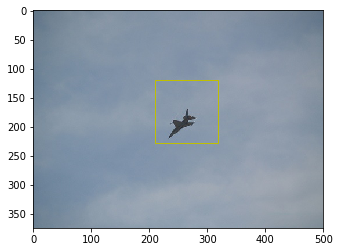

In [42]:
img_path = 'test/Images/000216.jpg'
boxes = test_single_1(img_path)
ploting(boxes)

recieved boxes
nms_done


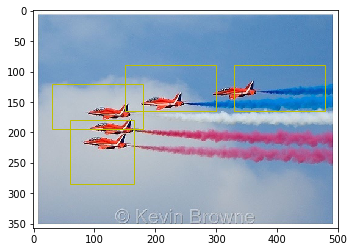

In [84]:
img_path = 'test/Images/006406.jpg'
boxes = test_single_1(img_path)
ploting(boxes)

recieved boxes
nms_done


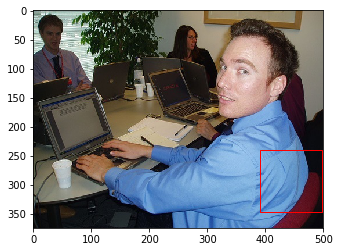

In [62]:
img_path = 'test/Images/000124.jpg'
boxes = test_single_1(img_path)
ploting(boxes)

recieved boxes
nms_done


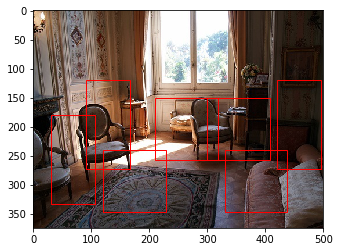

In [60]:
img_path = 'test/Images/000196.jpg'
boxes = test_single_1(img_path)
ploting(boxes)

recieved boxes
nms_done


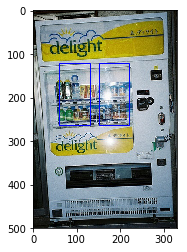

In [75]:
img_path = 'test/Images/000893.jpg'
boxes = test_single_1(img_path)
ploting(boxes)

recieved boxes
nms_done


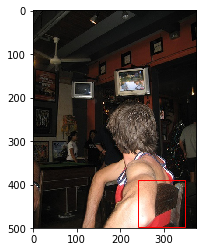

In [102]:
img_path = 'test/Images/000059.jpg'
boxes = test_single_1(img_path)
ploting(boxes)

### Bad Predictions

recieved boxes
nms_done


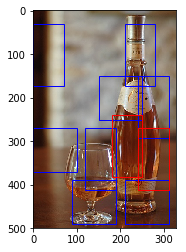

In [108]:
img_path = 'test/Images/003071.jpg'
boxes = test_single_1(img_path)
ploting(boxes)

recieved boxes
nms_done


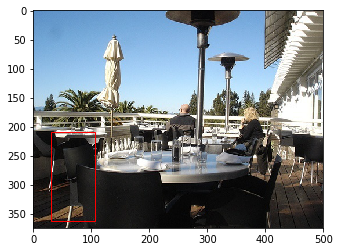

In [63]:
img_path = 'test/Images/000226.jpg'
boxes = test_single_1(img_path)
ploting(boxes)

recieved boxes
nms_done


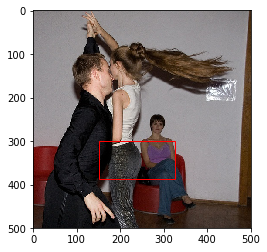

In [64]:
img_path = 'test/Images/000910.jpg'
boxes = test_single_1(img_path)
ploting(boxes)

recieved boxes
nms_done


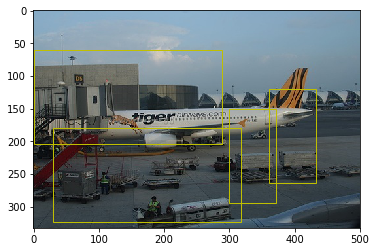

In [65]:
img_path = 'test/Images/000696.jpg'
boxes = test_single_1(img_path)
ploting(boxes)

recieved boxes
nms_done


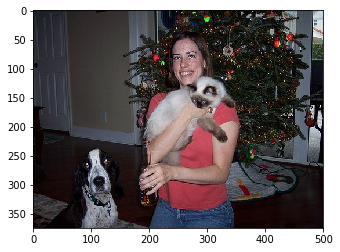

In [74]:
img_path = 'test/Images/000517.jpg'
boxes = test_single_1(img_path)
ploting(boxes)

## Two Layer Detection

In [71]:
def test_single_2(img_path):
    list_of_window_sizes = windows(img_path)         # get the 9 sliding windows for the image
    step_size=30
    model_concat = torch.load('model_concat.pth', map_location='cpu')

    # get predictions and apply NMS:
    boxes = sliding_window(model_concat,img_path,step_size,list_of_window_sizes)

    print('recieved boxes')

    boxes_for_all_objects = non_maximum_supression(boxes,probability_threshold = 0.95,threshold=0.2)
    print('nms_done')
    return boxes_for_all_objects

### Good Predictions

recieved boxes
nms_done


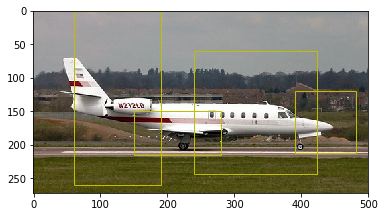

In [106]:
img_path = 'test/Images/000067.jpg'
boxes = test_single_2(img_path)
ploting(boxes)

recieved boxes
nms_done


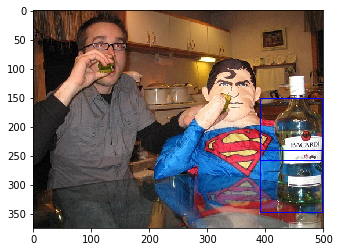

In [78]:
img_path = 'test/Images/000202.jpg'
boxes = test_single_2(img_path)
ploting(boxes)

recieved boxes
nms_done


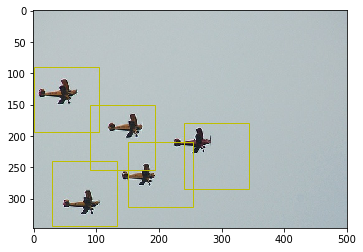

In [79]:
img_path = 'test/Images/000706.jpg'
boxes = test_single_2(img_path)
ploting(boxes)

recieved boxes
nms_done


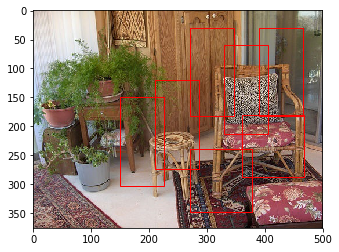

In [82]:
img_path = 'test/Images/000234.jpg'
boxes = test_single_2(img_path)
ploting(boxes)

recieved boxes
nms_done


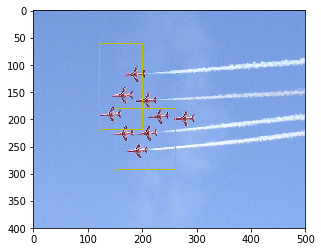

In [91]:
img_path = 'test/Images/000846.jpg'
boxes = test_single_2(img_path)
ploting(boxes)

recieved boxes
nms_done


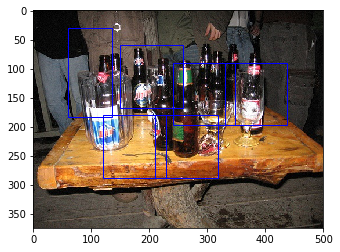

In [111]:
img_path = 'test/Images/000178.jpg'
boxes = test_single_2(img_path)
ploting(boxes)

### Bad Predictions

recieved boxes
nms_done


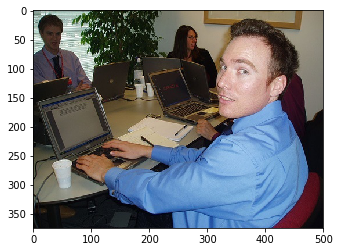

In [88]:
img_path = 'test/Images/000124.jpg'
boxes = test_single_2(img_path)
ploting(boxes)

recieved boxes
nms_done


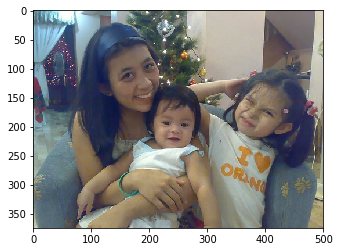

In [93]:
img_path = 'test/Images/001261.jpg'
boxes = test_single_2(img_path)
ploting(boxes)

(no prediction at all, everything background)

recieved boxes
nms_done


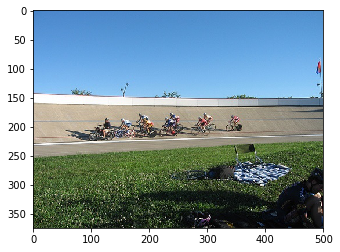

In [103]:
img_path = 'test/Images/000111.jpg'
boxes = test_single_2(img_path)
ploting(boxes)

recieved boxes
nms_done


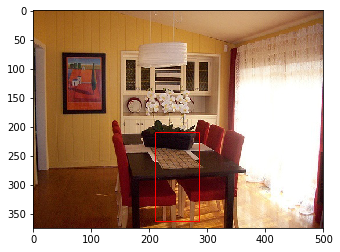

In [105]:
img_path = 'test/Images/000006.jpg'
boxes = test_single_2(img_path)
ploting(boxes)

recieved boxes
nms_done


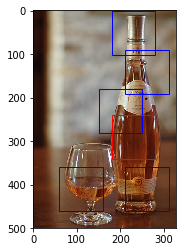

In [107]:
img_path = 'test/Images/003071.jpg'
boxes = test_single_2(img_path)
ploting(boxes)